### Multiple Parallel Input and Multi-step output

In [1]:
# multivariate output stacked lstm example
from numpy import array
from numpy import hstack, vstack
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, RepeatVector, TimeDistributed
from keras.layers.core import Dropout
from sklearn.preprocessing import MinMaxScaler
from pandas import read_csv
from pandas import DataFrame
import matplotlib.pyplot as plt
import numpy as np


# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

# define input sequence

# Read the data
data = read_csv('pollution2.csv', header=0, index_col=0)

# horizontally stack columns
raw_data = data.values
print(f'The shape of the raw_data before scaling is {raw_data.shape}')
#normalize input features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(raw_data)

n_train = 3000
#dataset = raw_data[0:n_train,:]
dataset = scaled_data[0:n_train,:]
# choose a number of time steps
n_steps_in, n_steps_out = 300, 30
# convert into input/output
X, y = split_sequences(dataset, n_steps_in, n_steps_out)
# the dataset knows the number of features, e.g. 2
n_features = X.shape[2]

# define model
model = Sequential()
model.add(LSTM(25, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(RepeatVector(n_steps_out))
model.add(LSTM(25, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(n_features)))
model.compile(optimizer='adam', loss='mse')
# fit model
train_history = model.fit(X, y, epochs=100, verbose=2, shuffle=False)

# demonstrate Direct prediction
# x_inp = raw_data[n_train:n_train+n_steps,:]
# x_inp = scaled_data[n_train:n_train+n_steps_in,:]
x_inp = scaled_data[0:300,:]
print(f'Initial shape of x_input {x_inp.shape}')
x_input = x_inp.reshape((1, n_steps_in, n_features))
yhat = model.predict(x_input, verbose=0)
print(f'The shape of yhat after prediction is {yhat.shape}')
yhat = yhat.reshape(n_steps_out, n_features)
print(f'The new shape of yhat  is {yhat.shape}')
inv_yhat = scaler.inverse_transform(yhat)
print(inv_yhat)

print("-------Learning Curve--------")
plt.plot(train_history.history['loss'], label='train')
# plt.plot(train_history.history['val_loss'], label='test')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


KeyboardInterrupt



In [ ]:
# # demonstrate Direct prediction
# # x_inp = raw_data[n_train:n_train+n_steps,:]
# lag = 0
# # x_inp = scaled_data[n_train+lag:n_train+n_steps_in+lag,:]
# x_inp = scaled_data[n_train - n_steps_in:n_train,:]
# print(f'Initial shape of x_input {x_inp.shape}')
# x_input = x_inp.reshape((1, n_steps_in, n_features))
# yhat = model.predict(x_input, verbose=0)
# print(f'The shape of yhat after prediction is {yhat.shape}')
# yhat = yhat.reshape(n_steps_out, n_features)
# print(f'The new shape of yhat  is {yhat.shape}')
# inv_yhat = scaler.inverse_transform(yhat)
# print(inv_yhat)

# print("-------Learning Curve--------")
# plt.plot(train_history.history['loss'], label='train')
# # plt.plot(train_history.history['val_loss'], label='test')
# plt.xlabel("Epochs")
# plt.ylabel("Loss")
# plt.legend()
# plt.show()

In [ ]:
attr = ["pollution", "dew point", "temperature", "pressure", "wind speed"]
for i in range(5):
    title = "Direct Prediction of "+str(attr[i])
#     actual = raw_data[8000:8030,i]
    actual = raw_data[n_train:n_train + n_steps_out,i]
    pred = inv_yhat.T
    plt.title(title)
    plt.xlabel("Timestep")
    plt.ylabel(attr[i])
    plt.plot(pred[i], label="predicted")
    plt.plot(actual, label="actual")
    plt.legend()
    plt.show()

In [16]:
# multivariate multi-step encoder-decoder lstm example

from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from pandas import DataFrame, read_csv
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
import numpy as np
import matplotlib.pyplot as plt

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 
# define input sequence
in_seq1 = array([10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 90, 80, 70, 60, 50, 40, 30])
in_seq2 = array([15, 25, 35, 45, 55, 65, 75, 85, 95, 105, 95, 85, 75, 65, 55, 45, 35])
out_seq = array([in_seq1[i]+in_seq2[i] for i in range(len(in_seq1))])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
# dataset = hstack((in_seq1, in_seq2, out_seq))
# print(dataset)
# choose a number of time steps
# n_steps_in, n_steps_out = 3, 5
# Read the data
data = read_csv('pollution2.csv', header=0, index_col=0)

# horizontally stack columns
raw_data = data.values
print(f'The shape of the raw_data before scaling is {raw_data.shape}')
#normalize input features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(raw_data)

n_train = 20000
#dataset = raw_data[0:n_train,:]
dataset = scaled_data[1:n_train,:]

# choose a number of time steps
# n_steps_in, n_steps_out = 2000, 1000
n_steps_in, n_steps_out = 50, 30
# convert into input/output
X, y = split_sequences(dataset, n_steps_in, n_steps_out)

# the dataset knows the number of features, e.g. 2
n_features = X.shape[2]
# print(X.shape)
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps_in, n_features)))
# model.add(LSTM(20))
model.add(RepeatVector(n_steps_out))
model.add(LSTM(50, activation='relu', return_sequences=True))
# model.add(LSTM(50, return_sequences=True))
# model.add(TimeDistributed(Dense(50, activation='relu')))
# model.add(TimeDistributed(Dense(n_features)))
model.add(TimeDistributed(Dense(n_features)))

model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=200, batch_size=64, verbose=2)
# demonstrate prediction
# x_input = array([[60, 65, 125], [70, 75, 145], [80, 85, 165]])
input_begin = 7000
input_end = input_begin + n_steps_in
output_end = input_end + n_steps_out
# x_input = dataset[2001:2031,:]
x_input = dataset[input_begin:input_end,:]
# print(x_input.shape)
x_input = x_input.reshape((1, n_steps_in, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat.shape)
yhat = yhat.reshape(n_steps_out, n_features)
print(yhat.shape)
# unscaled = DataFrame(scaler.inverse_transform(yhat))
# unscaled = unscaled.values
unscaled = scaler.inverse_transform(yhat)

model.summary()

# Calculate Error metrics
print("-----------ROOT MEAN SQUARED ERROR -----------------")
rmse_poll = sqrt(mean_squared_error(raw_data[input_end:output_end,0], unscaled[:,0]))
rmse_dew = sqrt(mean_squared_error(raw_data[input_end:output_end,1], unscaled[:,1]))
rmse_temp = sqrt(mean_squared_error(raw_data[input_end:output_end,2], unscaled[:,2]))
rmse_press = sqrt(mean_squared_error(raw_data[input_end:output_end,3], unscaled[:,3]))
rmse_wind = sqrt(mean_squared_error(raw_data[input_end:output_end,4], unscaled[:,4]))
print("Test RMSE: ", rmse_poll, rmse_dew, rmse_temp, rmse_press, rmse_wind)


print("----------------NORMALISED RMSE------------------------")
nrmse_poll = rmse_poll/(np.std(raw_data[input_end:output_end,0]))
nrmse_dew = rmse_dew/(np.std(raw_data[input_end:output_end,1]))
nrmse_temp = rmse_temp/(np.std(raw_data[input_end:output_end,2]))
nrmse_press = rmse_press/(np.std(raw_data[input_end:output_end,3]))
nrmse_wind = rmse_wind/(np.std(raw_data[input_end:output_end,4]))

n_rmse_poll = rmse_poll/(abs(max(raw_data[input_end:output_end,0]) - min(raw_data[input_end:output_end,0])))
n_rmse_dew = rmse_dew/(abs(max(raw_data[input_end:output_end,1]) - min(raw_data[input_end:output_end,1])))
n_rmse_temp = rmse_temp/(abs(max(raw_data[input_end:output_end,2]) - min(raw_data[input_end:output_end,2])))
n_rmse_press = rmse_press/(abs(max(raw_data[input_end:output_end,3]) - min(raw_data[input_end:output_end,3])))
n_rmse_wind = rmse_wind/(abs(max(raw_data[input_end:output_end,4]) - min(raw_data[input_end:output_end,4])))
print("Normalised RMSE: ", n_rmse_poll, n_rmse_dew, n_rmse_temp, n_rmse_press, n_rmse_wind)


print("------------------R-SQUARED VALUE---------------------")
r_sq1 = r2_score(raw_data[input_end:output_end,0], unscaled[:,0])
r_sq2 = r2_score(raw_data[input_end:output_end,1], unscaled[:,1])
r_sq3 = r2_score(raw_data[input_end:output_end,2], unscaled[:,2])
r_sq4 = r2_score(raw_data[input_end:output_end,3], unscaled[:,3])
r_sq5 = r2_score(raw_data[input_end:output_end,4], unscaled[:,4])
print("Test R-squared: ", r_sq1, r_sq2, r_sq3, r_sq4, r_sq5)



The shape of the raw_data before scaling is (43800, 5)
Epoch 1/200
312/312 - 15s - loss: 0.0172 - 15s/epoch - 47ms/step
Epoch 2/200
312/312 - 13s - loss: 0.0061 - 13s/epoch - 40ms/step
Epoch 3/200
312/312 - 13s - loss: 0.0058 - 13s/epoch - 40ms/step
Epoch 4/200
312/312 - 13s - loss: 0.0056 - 13s/epoch - 40ms/step
Epoch 5/200
312/312 - 13s - loss: 0.0055 - 13s/epoch - 41ms/step
Epoch 6/200
312/312 - 13s - loss: 0.0054 - 13s/epoch - 42ms/step
Epoch 7/200
312/312 - 13s - loss: 0.0053 - 13s/epoch - 42ms/step
Epoch 8/200
312/312 - 13s - loss: 0.0052 - 13s/epoch - 42ms/step
Epoch 9/200
312/312 - 13s - loss: 0.0052 - 13s/epoch - 42ms/step
Epoch 10/200
312/312 - 13s - loss: 0.0052 - 13s/epoch - 42ms/step
Epoch 11/200
312/312 - 13s - loss: 0.0051 - 13s/epoch - 42ms/step
Epoch 12/200
312/312 - 13s - loss: 0.0051 - 13s/epoch - 42ms/step
Epoch 13/200
312/312 - 13s - loss: 0.0050 - 13s/epoch - 43ms/step
Epoch 14/200
312/312 - 13s - loss: 0.0049 - 13s/epoch - 43ms/step
Epoch 15/200
312/312 - 13s - l

312/312 - 13s - loss: 0.0019 - 13s/epoch - 42ms/step
Epoch 125/200
312/312 - 13s - loss: 0.0019 - 13s/epoch - 43ms/step
Epoch 126/200
312/312 - 13s - loss: 0.0019 - 13s/epoch - 42ms/step
Epoch 127/200
312/312 - 14s - loss: 0.0019 - 14s/epoch - 43ms/step
Epoch 128/200
312/312 - 13s - loss: 0.0018 - 13s/epoch - 42ms/step
Epoch 129/200
312/312 - 13s - loss: 0.0018 - 13s/epoch - 42ms/step
Epoch 130/200
312/312 - 13s - loss: 0.0018 - 13s/epoch - 42ms/step
Epoch 131/200
312/312 - 13s - loss: 0.0018 - 13s/epoch - 42ms/step
Epoch 132/200
312/312 - 13s - loss: 0.0018 - 13s/epoch - 42ms/step
Epoch 133/200
312/312 - 13s - loss: 0.0018 - 13s/epoch - 42ms/step
Epoch 134/200
312/312 - 13s - loss: 0.0018 - 13s/epoch - 42ms/step
Epoch 135/200
312/312 - 13s - loss: 0.0018 - 13s/epoch - 42ms/step
Epoch 136/200
312/312 - 13s - loss: 0.0018 - 13s/epoch - 42ms/step
Epoch 137/200
312/312 - 13s - loss: 0.0018 - 13s/epoch - 42ms/step
Epoch 138/200
312/312 - 13s - loss: 0.0018 - 13s/epoch - 42ms/step
Epoch 139

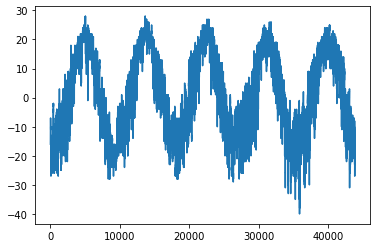

In [17]:
# plt.plot(raw_data[2031:2061,1])
plt.plot(raw_data[:,1])
plt.show()

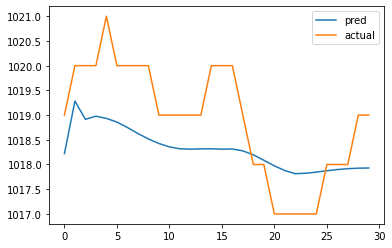

In [24]:
index = 3
plt.plot(unscaled[:,index], label="pred")
plt.plot(raw_data[input_end:output_end,index], label="actual")
plt.legend()
plt.show()


In [1]:
print("Python!")

Python!
